# BinSeg Segmentation
In this notebook, we use the BinSeg algorithm from the ruptures package to segment the challenge data.

In [8]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import ruptures as rpt
from sktime.annotation.plotting.utils import plot_time_series_with_change_points

from utils import load_has_data, to_submission

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First, we load the 250 time series (TS) as a pandas DataFrame. Each row corresponds to a twelve-dimensional TS and every column contains one channel of sensor data.

In [9]:
df = load_has_data()
df.head()

,x-acc,y-acc,z-acc,x-gyro,y-gyro,z-gyro,x-mag,y-mag,z-mag,lat,lon,speed
0,"[0.406, 0.7786, 0.70785, 0.5649, 0.268, -0.035...","[-0.4804, -0.19365, 0.4704, 0.6985, 0.45065, 0...","[1.775, 2.5445, 2.3076499999999998, 1.85993333...","[-0.2425, -0.1857, -0.0446, 0.0733, -0.0122, -...","[1.2022, 1.204, 1.2584, 1.4465, 1.6316, 1.5009...","[-0.0538, -0.0324, 0.0147, 0.0568, 0.0531, -0....","[-24.9, -23.4, -23.4, -23.4, -21.3, -21.3, -21...","[60.3, 62.0, 62.0, 62.0, 61.2, 61.2, 61.2, 62....","[-24.4, -26.1, -26.1, -26.1, -26.9, -26.9, -26...",[],[],[]
1,"[-0.2274, -0.2274, 0.1261, 0.1261, 0.1261, -0....","[0.5969, 0.5969, 0.1466, 0.1466, 0.1466, 0.515...","[-0.5992, -0.5992, -0.0643, -0.0643, -0.0643, ...","[-0.15955714285714287, -0.1613, -0.10250000000...","[-0.045385714285714286, -0.0391, -0.0080599999...","[-0.1735142857142857, -0.1772, -0.195, -0.2097...","[-29.4, -28.7, -28.7, -28.7, -29.1, -29.1, -29...","[-63.5, -62.4, -62.4, -62.4, -62.7, -62.7, -62...","[-52.2, -52.4, -52.4, -52.4, -52.2, -52.2, -52...",[],[],[]
2,"[4.8883, 4.8883, 4.8883, 4.4134, 4.4134, 4.413...","[5.4784, 5.4784, 5.4784, 5.8291, 5.8291, 5.829...","[-6.4445, -6.4445, -6.4445, -6.0946, -6.0946, ...","[0.060823076923076924, 0.08336, 0.0929, 0.2059...","[0.01392307692307692, -0.00486, -0.0012, 0.018...","[0.054430769230769234, 0.04057, 0.0391, 0.0824...","[-34.2, -34.2, -34.0, -34.0, -34.0, -34.0, -34...","[3.0, 3.0, 2.8, 2.8, 2.8, 4.3, 4.3, 4.3, 4.0, ...","[63.9, 63.9, 64.8, 64.8, 64.8, 64.9, 64.9, 64....",[],[],[]
3,"[-1.2656, -1.2656, -1.2656, -6.6303, -6.6303, ...","[-0.5253, -0.5253, -0.5253, -0.0624, -0.0624, ...","[-3.9209, -3.9209, -3.9209, -4.8733, -4.8733, ...","[-0.47177142857142856, -0.46897142857142854, -...","[0.7421142857142857, 0.44257142857142856, 0.26...","[-0.16341428571428573, -0.4535285714285714, -0...","[-1.7, -2.9, -2.9, -2.9, -4.9, -4.9, -4.9, -5....","[76.8, 75.4, 75.4, 75.4, 74.8, 74.8, 74.8, 74....","[-5.0, -3.7, -3.7, -3.7, -1.2, -1.2, -1.2, 1.5...",[],[],[]
4,"[-0.8136, -0.8136, -0.8136, -0.1624, -0.1624, ...","[-0.1392, -0.1392, -0.1392, -1.0283, -1.0283, ...","[0.844, 0.844, 0.844, 1.1861, 1.1861, 1.1861, ...","[-0.654675, -0.7183900000000001, -0.7294, -0.7...","[-0.021399999999999995, -0.11534, -0.1124, 0.0...","[0.032975, 0.05033, 0.0452, 0.03444, 0.0851099...","[10.6, 10.6, 10.6, 11.3, 11.3, 11.3, 12.1, 12....","[-69.2, -69.2, -69.2, -64.5, -64.5, -64.5, -60...","[-50.3, -50.3, -50.3, -53.5, -53.5, -53.5, -57...",[],[],[]


For demonstration, we segment one channel and only a subset of the 250 TS. We plot the segmentations and store the change points (CPs) for the submission.

Using channel: y-acc


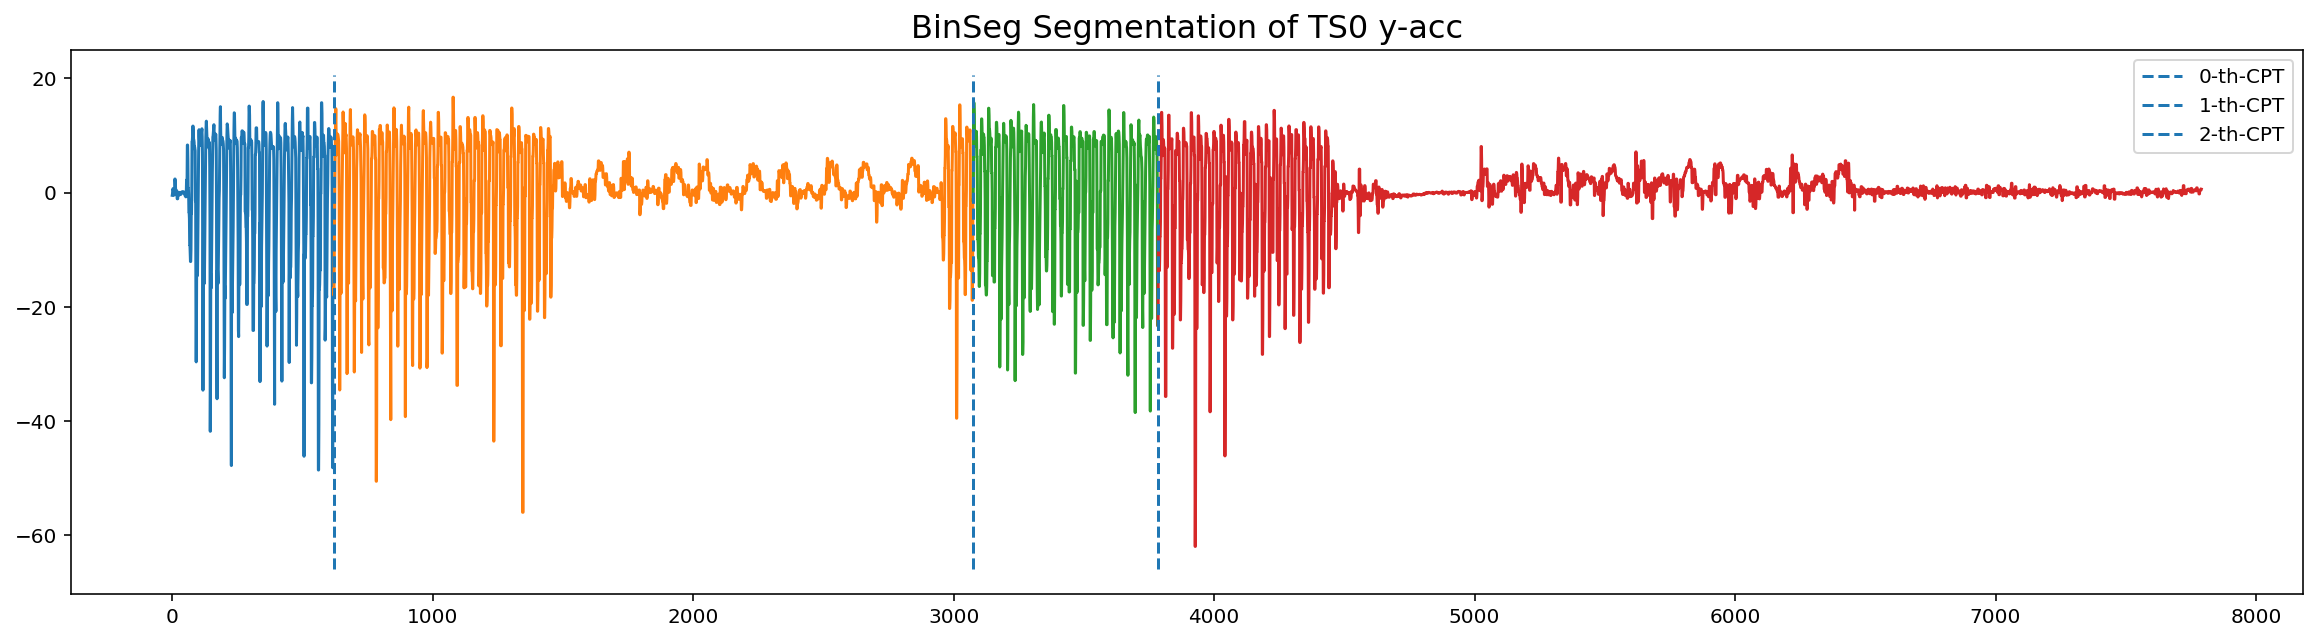

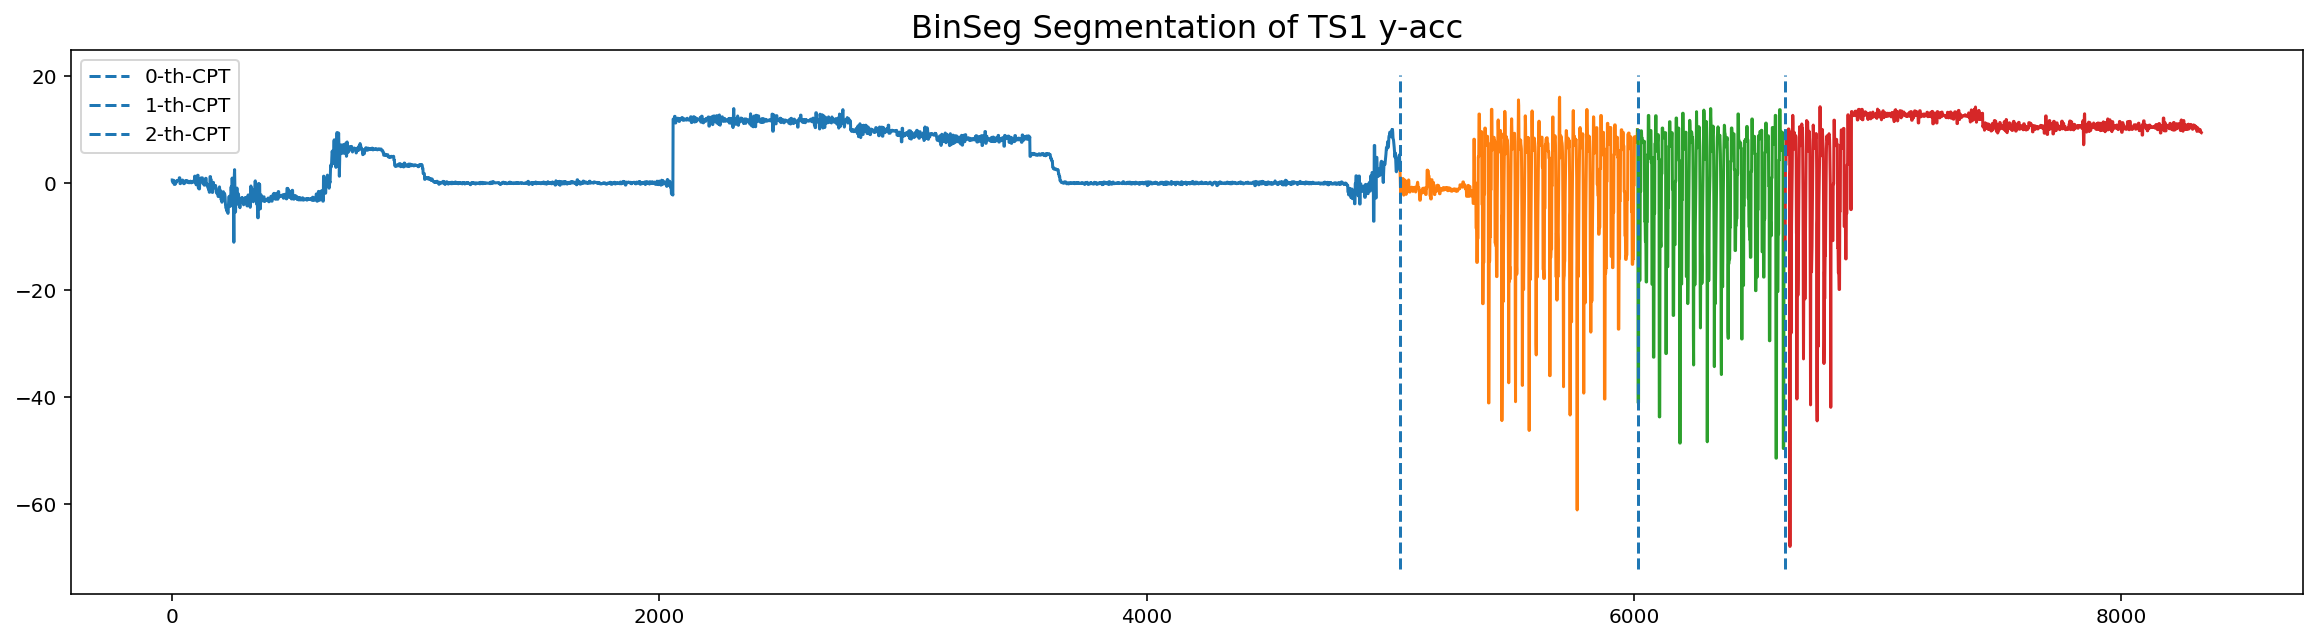

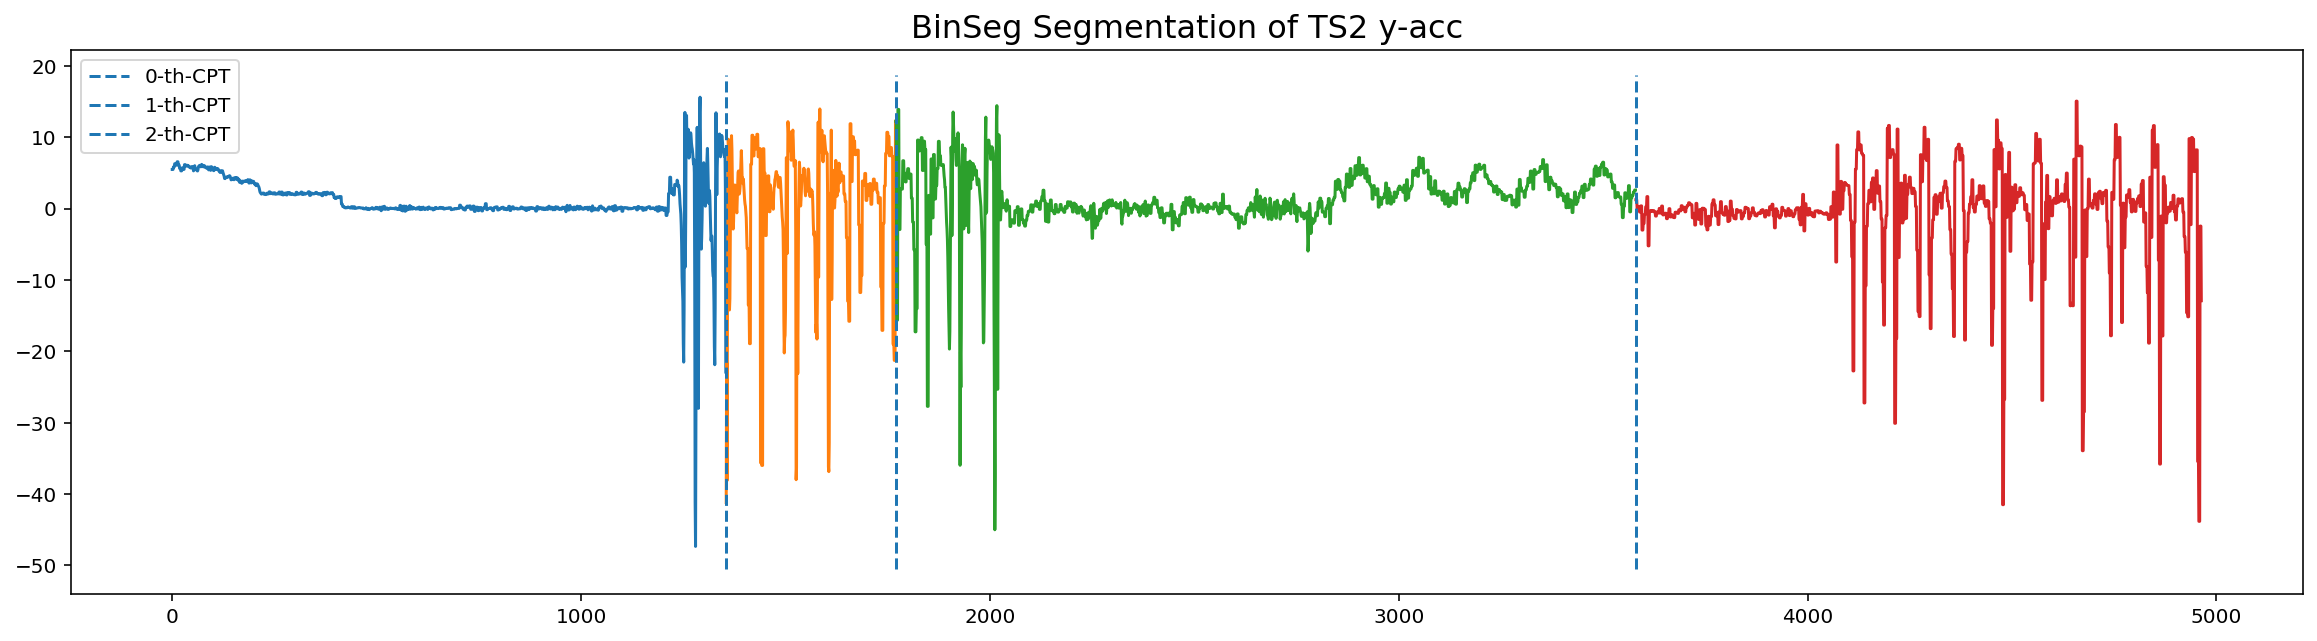

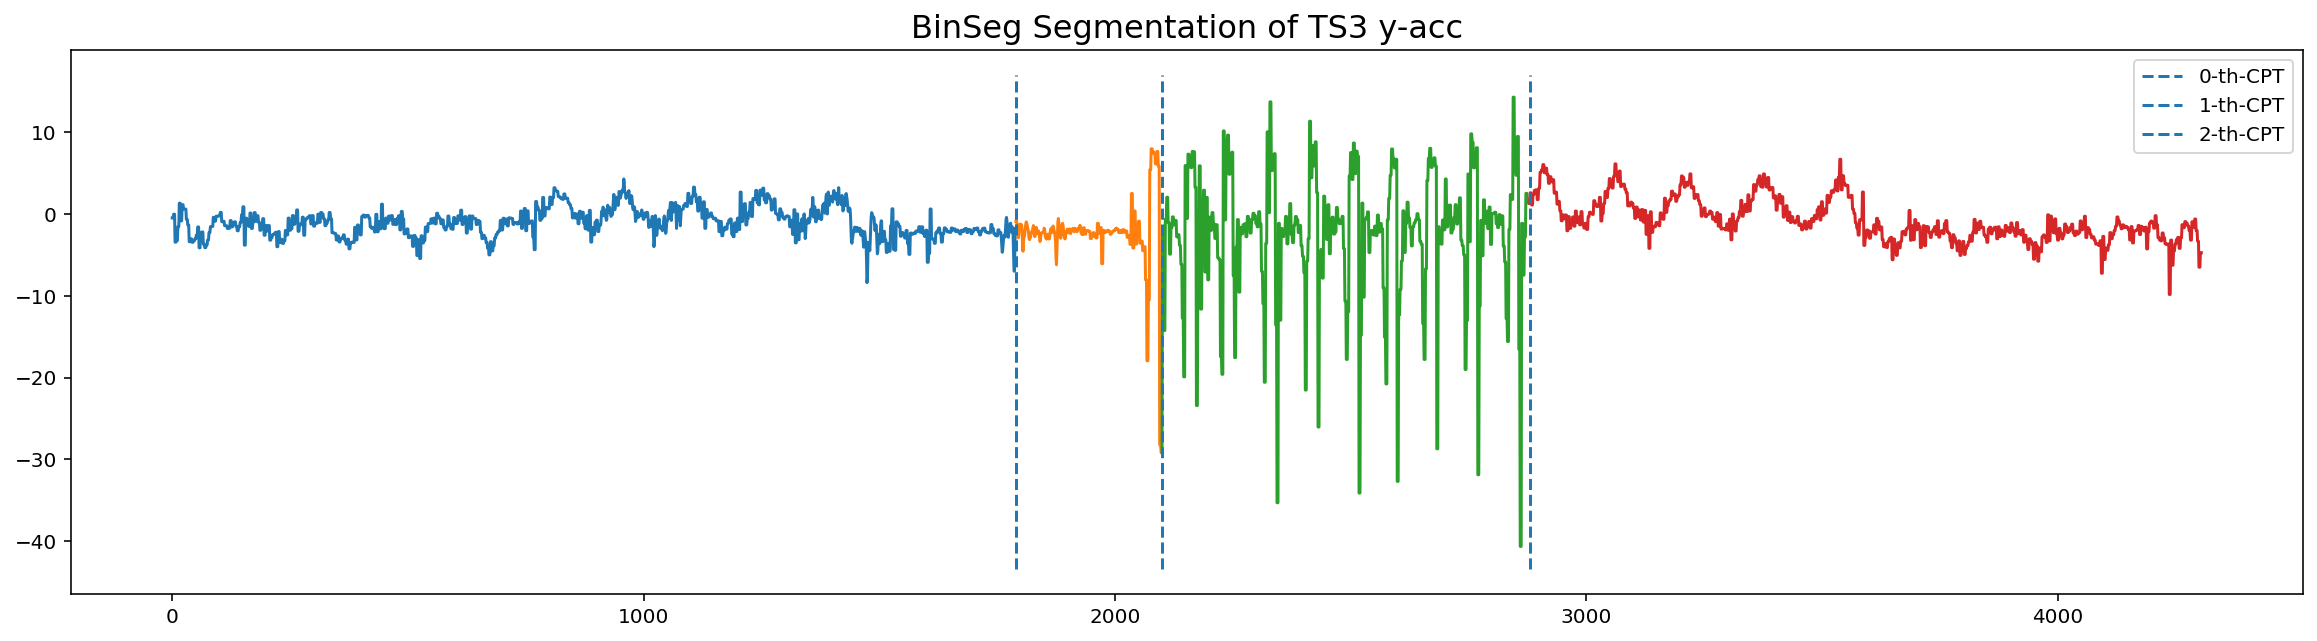

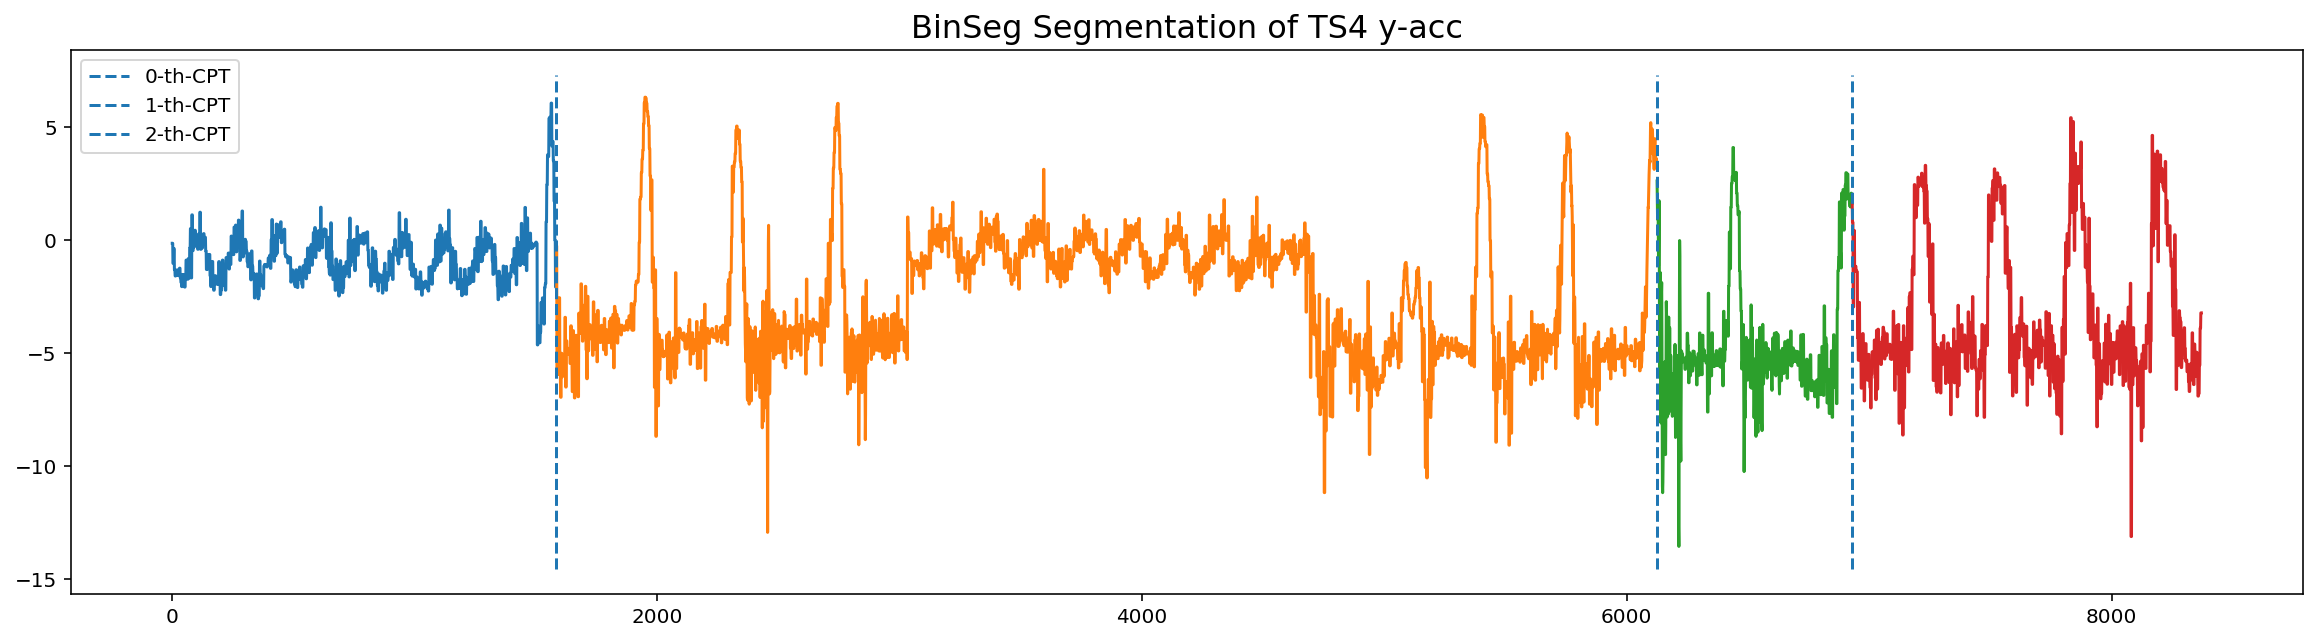

In [10]:
# use only one channel
channel = "y-acc"
# channels = ["x-acc", "y-acc", "z-acc", "x-gyro", "y-gyro", "z-gyro"]
print(f"Using channel: {channel}")

# segment the first 5 TS
subset = 5
change_points = []

for idx, row in df.iloc[:subset,:].iterrows():
    ts = row[channel]

    binseg = rpt.Binseg(model="ar", min_size=int(ts.shape[0] * .05)).fit(ts)
    found_cps = np.array(binseg.predict(n_bkps=3)[:-1], dtype=np.int64)
    change_points.append(found_cps)

    fig, ax = plot_time_series_with_change_points(f"BinSeg Segmentation of TS{idx} {channel}", pd.Series(ts), found_cps)
    plt.show()

To make a submission, simply run the last cell for all 250 TS and then format the CPs in the correct way and hand in your results.

In [11]:
submission = to_submission(df.iloc[:subset,:], change_points)
submission.head()
# submission.to-csv("submission.csv", index=False)

,Id,Offsets
0,0,1 620
1,0,621 2455
2,0,3076 710
3,0,3786 4005
4,1,1 5040
